# Importing Data

In [1]:
from sklearn.metrics import r2_score
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')
import sklearn.metrics as metrics
import math
from scipy import stats
from scipy.stats import norm, skew

from sklearn.model_selection import cross_val_score, GridSearchCV, KFold
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.svm import SVR, LinearSVR
from sklearn.linear_model import ElasticNet, SGDRegressor, BayesianRidge
from sklearn.kernel_ridge import KernelRidge
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import warnings
warnings.filterwarnings('ignore')

In [2]:
all_data = pd.read_csv('./input/train.csv')

In [3]:
all_data.shape

(1460, 81)

In [4]:
#Save the 'Id' column
train_ID = all_data['Id']
#Dropping the  'Id' column
all_data.drop("Id", axis = 1, inplace = True)

#check again the data size after dropping the 'Id' variable
print("The train data size after dropping Id feature is : {} ".format(all_data.shape)) 

The train data size after dropping Id feature is : (1460, 80) 


## Data Outliers

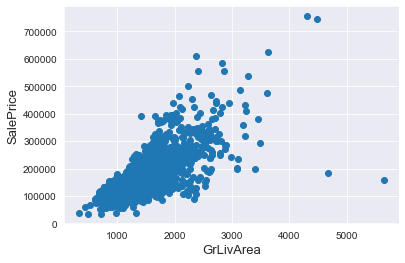

In [5]:
fig, ax = plt.subplots()
ax.scatter(x = all_data['GrLivArea'], y = all_data['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

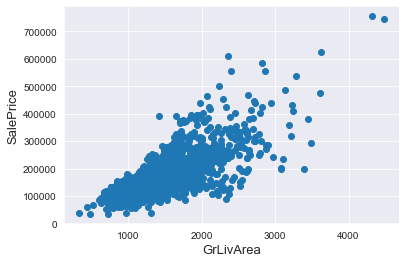

In [6]:
#Deleting outliers
all_data = all_data.drop(all_data[(all_data['GrLivArea']>4000) 
                         & (all_data['SalePrice']<300000)].index)

#Checking
fig, ax = plt.subplots()
ax.scatter(all_data['GrLivArea'], all_data['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

## Target Variable Analysis and Transformation


 mu = 180932.92 and sigma = 79467.79



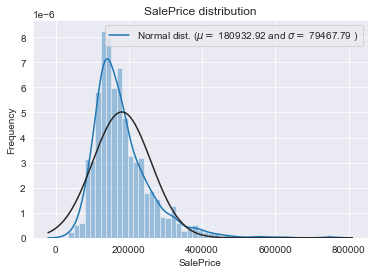

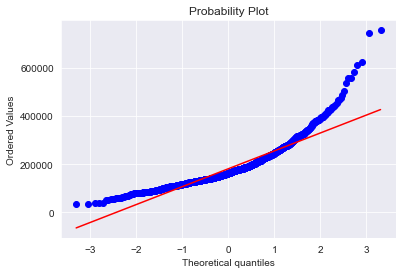

In [7]:
sns.distplot(all_data['SalePrice'] , fit=norm);

# The fitted parameters used by the function
(mu, sigma) = norm.fit(all_data['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

# The distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')
# The QQ-plot
fig = plt.figure()
res = stats.probplot(all_data['SalePrice'], plot=plt)
plt.show()

The target variable is right skewed.
For linear models its better to have normally distributed data , so we to transform this variable and make it more normally distributed.


 mu = 12.02 and sigma = 0.40



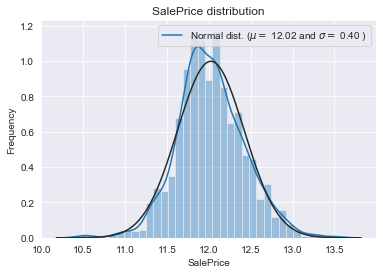

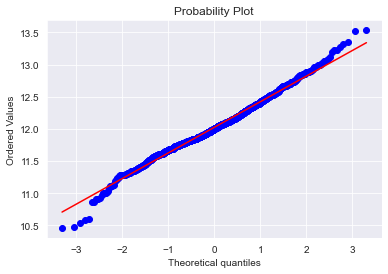

In [8]:
#We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
all_data["SalePrice"] = np.log1p(all_data["SalePrice"])

sns.distplot(all_data['SalePrice'] , fit=norm);

# The fitted parameters used by the function
(mu, sigma) = norm.fit(all_data['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

# The distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

# The QQ-plot
fig = plt.figure()
res = stats.probplot(all_data['SalePrice'], plot=plt)
plt.show()

# Feature Engineering

In [9]:
ntrain = all_data.shape[0]
Y = all_data[['SalePrice']]
all_data = all_data.reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)
print("Entire data size is : {}".format(all_data.shape))

Entire data size is : (1458, 79)


### Imputing Missing Data

In [10]:
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head(20)

,Missing Ratio
PoolQC,99.588477
MiscFeature,96.296296
Alley,93.758573
Fence,80.727023
FireplaceQu,47.325103
LotFrontage,17.764060
GarageType,5.555556
GarageYrBlt,5.555556
GarageFinish,5.555556
GarageQual,5.555556


In [11]:
# PoolQC : data description says NA means "No Pool"
all_data["PoolQC"] = all_data["PoolQC"].fillna("None")

# MiscFeature : data description says NA means "no misc feature"
all_data["MiscFeature"] = all_data["MiscFeature"].fillna("None")

# Alley : data description says NA means "no alley access"
all_data["Alley"] = all_data["Alley"].fillna("None")

# Fence : data description says NA means "no fence"
all_data["Fence"] = all_data["Fence"].fillna("None")

# FireplaceQu : data description says NA means "no fireplace"
all_data["FireplaceQu"] = all_data["FireplaceQu"].fillna("None")

# Lot Frontage : Group by neighborhood and fill in missing value by the median LotFrontage of all the neighborhood
all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))

# GarageType, GarageFinish, GarageQual and GarageCond : Replacing missing data with None
for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    all_data[col] = all_data[col].fillna('None')

# GarageYrBlt, GarageArea and GarageCars : Replacing missing data with 0
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    all_data[col] = all_data[col].fillna(0)

# BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, BsmtFullBath and BsmtHalfBath : Missing values are 0 for no basement
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    all_data[col] = all_data[col].fillna(0)
    
# BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1 and BsmtFinType2 : NaN means that there is no basement
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    all_data[col] = all_data[col].fillna('None')

# MasVnrArea and MasVnrType : NA most likely means no masonry veneer for these houses
# We can fill 0 for the area and None for the type
all_data["MasVnrType"] = all_data["MasVnrType"].fillna("None")
all_data["MasVnrArea"] = all_data["MasVnrArea"].fillna(0)

# MSZoning (The general zoning classification) : Fill in missing values with 'RL' which is most common
all_data['MSZoning'] = all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0])

# Utilities : Almost all records are "AllPub" so we drop it
all_data = all_data.drop(['Utilities'], axis=1)

# Functional : Data description says NA means typical
all_data["Functional"] = all_data["Functional"].fillna("Typ")

# Electrical, KitchenQual, Exterior1st, Exterior2nd, SaleType: They have one NA. We put the most common value there
all_data['Electrical'] = all_data['Electrical'].fillna(all_data['Electrical'].mode()[0])
all_data['KitchenQual'] = all_data['KitchenQual'].fillna(all_data['KitchenQual'].mode()[0])
all_data['Exterior1st'] = all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0])
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0])
all_data['SaleType'] = all_data['SaleType'].fillna(all_data['SaleType'].mode()[0])

# MSSubClass : Na  means No building class. We replace missing values with None
all_data['MSSubClass'] = all_data['MSSubClass'].fillna("None")

In [12]:
#Checking for any remaining missing values 
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head()

,Missing Ratio


### Deleting Low Variance Data

Pave    1452
Grvl       6
Name: Street, dtype: int64

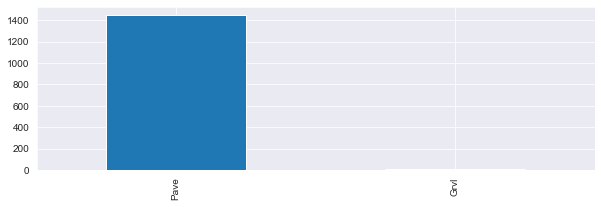

In [13]:
all_data['Street'].value_counts().plot(kind='bar',figsize=[10,3])
all_data['Street'].value_counts() 

Norm      1444
Feedr        6
Artery       2
RRNn         2
PosA         1
PosN         1
RRAn         1
RRAe         1
Name: Condition2, dtype: int64

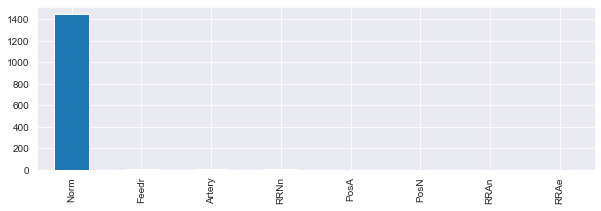

In [14]:
all_data['Condition2'].value_counts().plot(kind='bar',figsize=[10,3])
all_data['Condition2'].value_counts() 

CompShg    1433
Tar&Grv      11
WdShngl       6
WdShake       5
Metal         1
Membran       1
Roll          1
Name: RoofMatl, dtype: int64

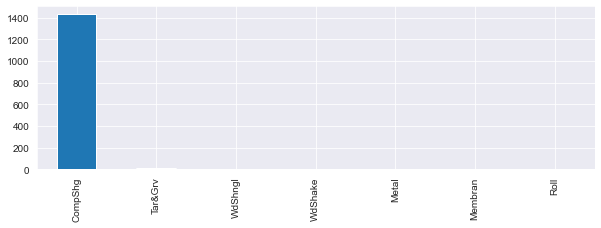

In [15]:
all_data['RoofMatl'].value_counts().plot(kind='bar',figsize=[10,3])
all_data['RoofMatl'].value_counts() 

GasA     1426
GasW       18
Grav        7
Wall        4
OthW        2
Floor       1
Name: Heating, dtype: int64

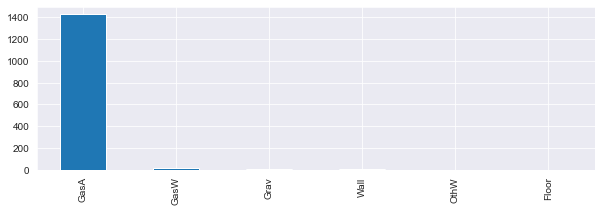

In [16]:
all_data['Heating'].value_counts().plot(kind='bar',figsize=[10,3])
all_data['Heating'].value_counts() #======> Drop feature one Type


In [17]:
all_data = all_data.drop(['Heating','RoofMatl','Condition2','Street'],axis=1)

### Creating New Features

In [18]:
all_data['Age_House']= (all_data['YrSold']-all_data['YearBuilt'])
all_data['Age_House'].describe()

count    1458.000000
mean       36.598080
std        30.240565
min         0.000000
25%         8.000000
50%        35.000000
75%        54.000000
max       136.000000
Name: Age_House, dtype: float64

In [19]:
# The minimum of age of some house is -1 for some reason
Negatif = all_data[all_data['Age_House'] < 0]
Negatif

,MSSubClass,MSZoning,LotFrontage,LotArea,Alley,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,Age_House


In [20]:
#We change the year sold to 2009 as it the value of 'YearRemodAdd'
all_data.loc[all_data['YrSold'] < all_data['YearBuilt'],'YrSold' ] = 2009
all_data['Age_House']= (all_data['YrSold']-all_data['YearBuilt'])
all_data['Age_House'].describe()

count    1458.000000
mean       36.598080
std        30.240565
min         0.000000
25%         8.000000
50%        35.000000
75%        54.000000
max       136.000000
Name: Age_House, dtype: float64

In [21]:
# TotalBsmtBath : BsmtFullBath + 1/2 BsmtHalfBath
all_data['TotalBsmtBath'] = all_data['BsmtFullBath'] + all_data['BsmtFullBath']*0.5

# TotalBath : FullBath + 1/2 HalfBath
all_data['TotalBath'] = all_data['FullBath'] + all_data['HalfBath']*0.5 

# TotalSA : 1stFlrSF + 2ndFlrSF + TotalBsmtSF
all_data['TotalSA']=all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']

In [22]:
all_data.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Alley,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,...,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,Age_House,TotalBsmtBath,TotalBath,TotalSA
0,60,RL,65.0,8450,None,Reg,Lvl,Inside,Gtl,CollgCr,...,None,0,2,2008,WD,Normal,5,1.5,2.5,2566
1,20,RL,80.0,9600,None,Reg,Lvl,FR2,Gtl,Veenker,...,None,0,5,2007,WD,Normal,31,0.0,2.0,2524
2,60,RL,68.0,11250,None,IR1,Lvl,Inside,Gtl,CollgCr,...,None,0,9,2008,WD,Normal,7,1.5,2.5,2706
3,70,RL,60.0,9550,None,IR1,Lvl,Corner,Gtl,Crawfor,...,None,0,2,2006,WD,Abnorml,91,1.5,1.0,2473
4,60,RL,84.0,14260,None,IR1,Lvl,FR2,Gtl,NoRidge,...,None,0,12,2008,WD,Normal,8,1.5,2.5,3343


### Encoding categorical variables

In [23]:
# Mapping ordinal categories from 0 to N

# Map Prepared according to the data description
bin_map  = {'TA':2,'Gd':3, 'Fa':1,'Ex':4,'Po':1,'None':0,'Y':1,'N':0,'Reg':3,'IR1':2,'IR2':1,'IR3':0,"None" : 0,
            "No" : 2, "Mn" : 2, "Av": 3,"Gd" : 4,"Unf" : 1, "LwQ": 2, "Rec" : 3,"BLQ" : 4, "ALQ" : 5, "GLQ" : 6
            }
all_data['ExterQual'] = all_data['ExterQual'].map(bin_map)
all_data['ExterCond'] = all_data['ExterCond'].map(bin_map)
all_data['BsmtCond'] = all_data['BsmtCond'].map(bin_map)
all_data['BsmtQual'] = all_data['BsmtQual'].map(bin_map)
all_data['HeatingQC'] = all_data['HeatingQC'].map(bin_map)
all_data['KitchenQual'] = all_data['KitchenQual'].map(bin_map)
all_data['FireplaceQu'] = all_data['FireplaceQu'].map(bin_map)
all_data['GarageQual'] = all_data['GarageQual'].map(bin_map)
all_data['GarageCond'] = all_data['GarageCond'].map(bin_map)
all_data['CentralAir'] = all_data['CentralAir'].map(bin_map)
all_data['LotShape'] = all_data['LotShape'].map(bin_map)
all_data['BsmtExposure'] = all_data['BsmtExposure'].map(bin_map)
all_data['BsmtFinType1'] = all_data['BsmtFinType1'].map(bin_map)
all_data['BsmtFinType2'] = all_data['BsmtFinType2'].map(bin_map)

PavedDrive =   {"N" : 0, "P" : 1, "Y" : 2}
all_data['PavedDrive'] = all_data['PavedDrive'].map(PavedDrive)

In [24]:
#Select categorical features
rest_object_columns = all_data.select_dtypes(include=['object'])
#Using One hot encoder
object_columns_df = pd.get_dummies(all_data, columns=rest_object_columns.columns)
all_data = all_data.drop(columns=rest_object_columns.columns)
all_data = pd.concat([object_columns_df], axis=1,sort=False)
all_data.head()

,MSSubClass,LotFrontage,LotArea,LotShape,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,60,65.0,8450,3,7,5,2003,2003,196.0,4,...,0,0,0,1,0,0,0,0,1,0
1,20,80.0,9600,3,6,8,1976,1976,0.0,2,...,0,0,0,1,0,0,0,0,1,0
2,60,68.0,11250,2,7,5,2001,2002,162.0,4,...,0,0,0,1,0,0,0,0,1,0
3,70,60.0,9550,2,7,5,1915,1970,0.0,2,...,0,0,0,1,1,0,0,0,0,0
4,60,84.0,14260,2,8,5,2000,2000,350.0,4,...,0,0,0,1,0,0,0,0,1,0


In [25]:
# Checking if any Categorical Data Left
all_data.select_dtypes(include=['object']).shape

(1458, 0)

In [26]:
# Train-Test Separation
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(all_data, Y, test_size=0.20, random_state=12345)
print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

(1166, 221) (292, 221) (1166, 1) (292, 1)


# Modeling

In [27]:
#Validation function

def rmse_cv(model,X,y):
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=5))
    return rmse

In [28]:
# All the regression models to be tried

models = []
models.append(('Linear Regression', LinearRegression()))
models.append(('Ridge Regression', Ridge()))
models.append(('Lasso Regression', Lasso(alpha=0.01,max_iter=100000)))
models.append(('Random Forest Regressor', RandomForestRegressor()))
models.append(('eXtreme Gradient Boost Regressor', GradientBoostingRegressor()))
models.append(("Support Vector Regressor", SVR()))
models.append(("Bayesian Ridge Regressor", BayesianRidge()))
models.append(("XGB Regressor", XGBRegressor()))
models.append(("Elastic Net Regressor", ElasticNet(alpha=0.001,max_iter=10000)))
models.append(("Extra Trees Regressor", ExtraTreesRegressor()))
models.append(("LGBM Regressor", LGBMRegressor()))

# evaluate each model in turn
results = []
names = []

In [29]:
# Getting the rmse score on the train data
for name, model in models:
        score = rmse_cv(model, X_train, Y_train.values.ravel())
        print('\033[4m'+"{}: {:.6f}".format(name,score.mean())+'\033[0m')

Linear Regression: 0.152362
Ridge Regression: 0.119077
Lasso Regression: 0.127780
Random Forest Regressor: 0.135474
eXtreme Gradient Boost Regressor: 0.122101
Support Vector Regressor: 0.202157
Bayesian Ridge Regressor: 0.114587
XGB Regressor: 0.134174
Elastic Net Regressor: 0.113127
Extra Trees Regressor: 0.129431
LGBM Regressor: 0.125441


In [30]:
# getting the r2 score
for name, model in models:
    model.fit(X_train,Y_train)
    Y_pred=model.predict(X_test)
    score=r2_score(Y_test, Y_pred)*100
    print('\033[4m'+"{}: {:.6f}".format(name,score.mean())+'\033[0m')

Linear Regression: 86.685352
Ridge Regression: 89.623842
Lasso Regression: 86.908380
Random Forest Regressor: 83.917293
eXtreme Gradient Boost Regressor: 88.262732
Support Vector Regressor: 71.880489
Bayesian Ridge Regressor: 89.756005
XGB Regressor: 86.348760
Elastic Net Regressor: 90.363018
Extra Trees Regressor: 86.875254
LGBM Regressor: 85.875735


## After checking the rmse and the r2 score
## Elastic Net Regressor is chosen

In [31]:
# from numpy import arange
# from sklearn.model_selection import GridSearchCV
# from sklearn.model_selection import RepeatedKFold
# model = ElasticNet()
# # define model evaluation method
# cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# # define grid
# grid = dict()
# grid['alpha'] = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.0, 1.0, 10.0, 100.0]
# grid['l1_ratio'] = arange(0, 1, 0.01)
# # define search
# search = GridSearchCV(model, grid, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# # perform the search
# results = search.fit(X_train, Y_train)
# # summarize
# print('MAE: %.3f' % results.best_score_)
# print('Config: %s' % results.best_params_)

MAE: -0.079
Config: {'alpha': 0.001, 'l1_ratio': 0.5}


In [32]:
els=ElasticNet(alpha=0.001, l1_ratio= 0.5,max_iter=10000)
els.fit(X_train,Y_train)
Y_pred=els.predict(X_test)
Y_train_pred=els.predict(X_train)

In [33]:
print("R2 score for test data : {:.6f}".format(r2_score(Y_test, Y_pred)*100))
print("R2 score for train data : {:.6f}".format(r2_score(Y_train, Y_train_pred)*100))

R2 score for test data : 90.363018
R2 score for train data : 93.951944


## The Model does not  seems to be overfitted or underfitted

# The accuracy score for the regression model is 90.36%